In [95]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [96]:
pred_path = '../outputs/2024-01-19/10-32-24/preds'
label_path = '../data/raw/train_kelp'

In [97]:
import glob

# get all file names inside the pred path
pred_files = glob.glob(pred_path + '/*.tif')

In [98]:
from tqdm import tqdm
import rasterio

# load all predictions and labels
preds = []
labels = []
for pred_file in tqdm(pred_files):
    # load prediction
    with rasterio.open(pred_file) as src:
        pred = src.read(1)
    preds.append(pred)
    
    # load label
    label_name = os.path.basename(pred_file).replace('pred', 'kelp')
    label_file = os.path.join(label_path, label_name)
    with rasterio.open(label_file) as src:
        label = src.read(1)
    labels.append(label)

  0%|          | 0/1127 [00:00<?, ?it/s]C:\Users\EmielW\Epoch\Competitions\q2-detect-kelp\venv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.

100%|██████████| 1127/1127 [00:09<00:00, 120.45it/s]


In [99]:
# convert to numpy array
preds = np.array(preds)
labels = np.array(labels)

In [100]:
# define the objective
dice = lambda x, y: 2 * np.sum(x * y) / (np.sum(x) + np.sum(y))

In [101]:
# calculate dice score across the dataset for each threshold
thresholds = np.arange(0, 1, 0.01)
dice_scores = []
for threshold in tqdm(thresholds):
    dice_scores.append(dice(preds > threshold, labels))

100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


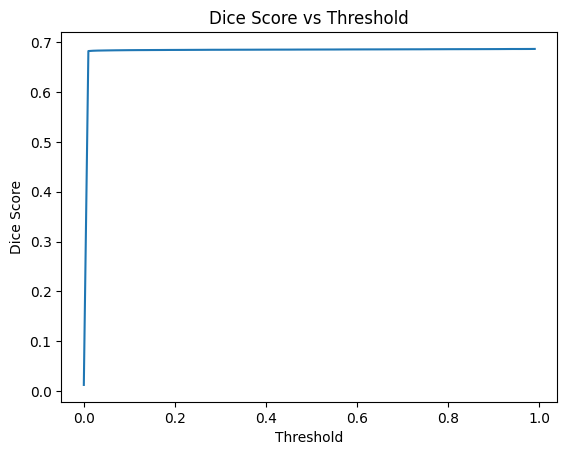

In [102]:
# plot dice score vs threshold
plt.plot(thresholds, dice_scores)
plt.xlabel('Threshold')
plt.ylabel('Dice Score')
plt.title('Dice Score vs Threshold')
plt.show()

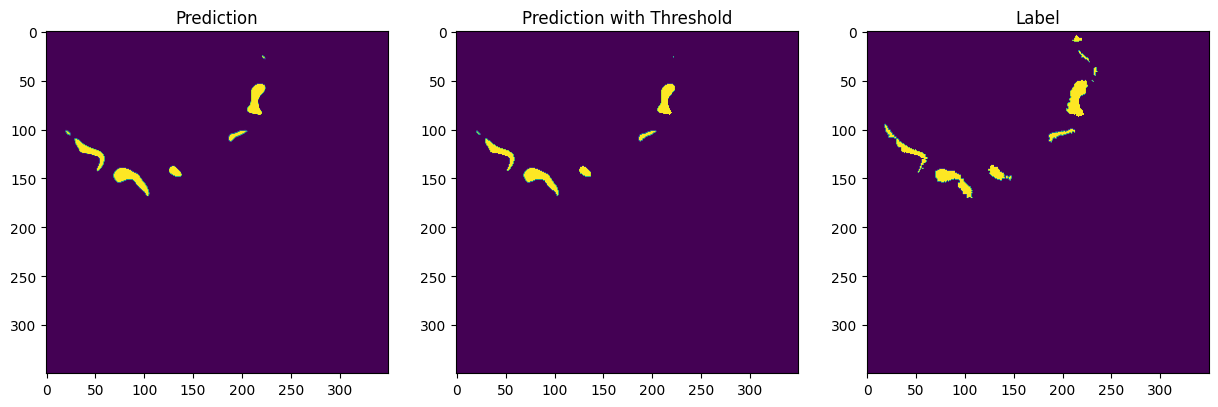

In [103]:
# plot a prediction, versus the prediction with threshold, and the label next to each other
idx = 26
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(preds[idx])
ax[0].set_title('Prediction')

thresh = thresholds[np.argmax(dice_scores)]
ax[1].imshow(preds[idx] > thresh)
ax[1].set_title('Prediction with Threshold')

ax[2].imshow(labels[idx])
ax[2].set_title('Label')

plt.show()

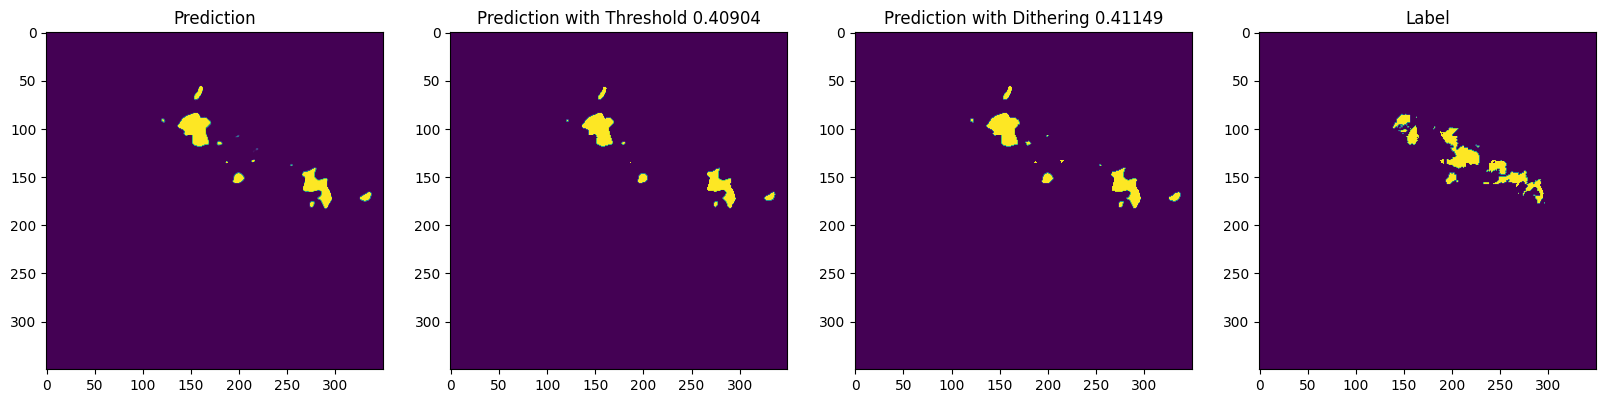

<Figure size 640x480 with 0 Axes>

In [108]:
# plot a prediction, versus the prediction with threshold, and the prediction with dithering, and label
idx = 0
_, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=100)
ax[0].imshow(preds[idx])
ax[0].set_title('Prediction')

thresh = 0.9949
ax[1].imshow(preds[idx] > thresh)
ax[1].set_title(f'Prediction with Threshold {dice(preds[idx] > thresh, labels[idx]):.5f}')

rands = np.random.rand(*preds[idx].shape)
dithered = preds[idx] > rands
ax[2].imshow(dithered)
ax[2].set_title(f'Prediction with Dithering {dice(dithered, labels[idx]):.5f}')

ax[3].imshow(labels[idx])
ax[3].set_title('Label')

plt.show()
plt.savefig('dithering.svg')

Score without threshold on floating preds: 0.68488
Dithered Dice Score: 0.68478
Score with optimal threshold: 0.68626


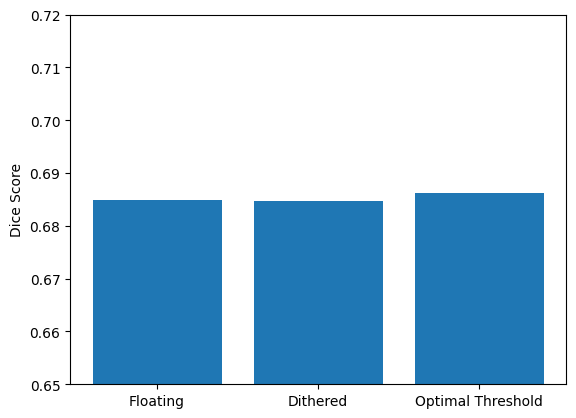

In [156]:
# compute the score if dithering the entire dataset
dithered_preds = preds > np.random.rand(*preds.shape)
dithered_dice = dice(dithered_preds, labels)
print(f'Score without threshold on floating preds: {dice(preds, labels):.5f}')
print(f'Dithered Dice Score: {dithered_dice:.5f}')
print(f'Score with optimal threshold: {max(dice_scores):.5f}')

# show bar chart
plt.bar(['Floating', 'Dithered', 'Optimal Threshold'], [dice(preds, labels), dithered_dice, max(dice_scores)])
plt.ylabel('Dice Score')

# set scale
plt.ylim([0.65, 0.72])
plt.show()

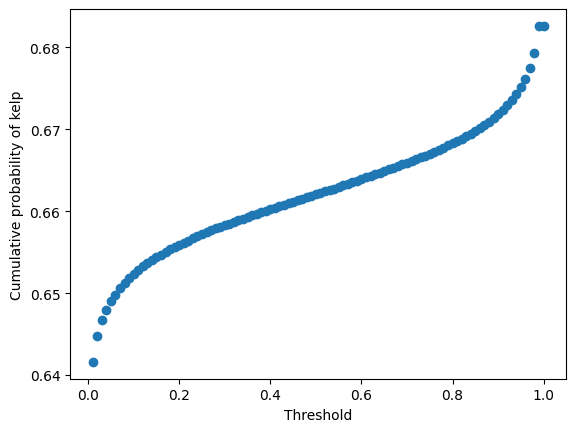

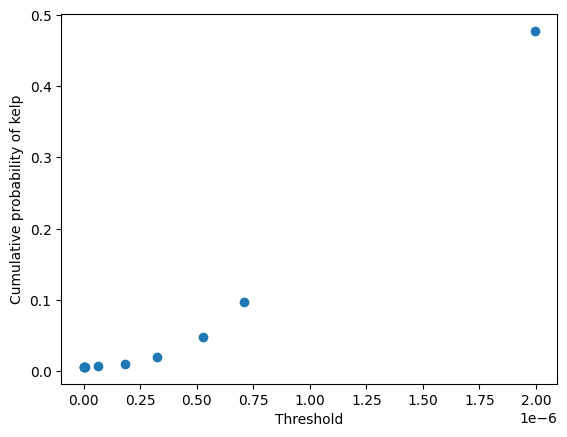

In [146]:
# Plot the prediction versus the probability of being kelp
x = np.concatenate([np.arange(0.0,1,0.01)])

# also add some percentiles to the x values
x = np.concatenate([x, np.percentile(preds.flatten(), [1, 5, 10, 25, 50, 75, 90, 95, 99,99.99])])

y = np.array([np.mean(labels[preds>t].flatten()) for t in x])

# set the value at 1 to be the same as the largest value
y = np.append(y, max(y))
x = np.append(x, 1)

# plot the large points
plt.scatter(x[y>0.5],y[y>0.5])
plt.xlabel('Threshold')
plt.ylabel('Cumulative probability of kelp')
plt.show()

# plot the small points
plt.scatter(x[y<0.5],y[y<0.5])
plt.xlabel('Threshold')
plt.ylabel('Cumulative probability of kelp')
plt.show()

In [147]:
# Convert y to a mapping with linear interpolation
from scipy.interpolate import interp1d
f = interp1d(x,y)

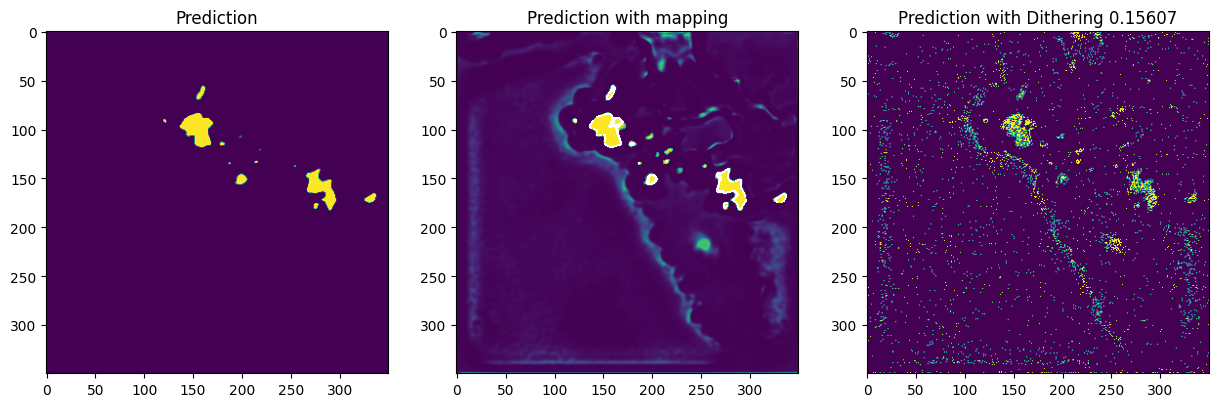

Dithered Dice Score: 0.17244


In [148]:
# Convert the prediction to probability of being kelp with the mapping
preds_prob = f(preds)

# apply dithering again
dithered_preds_prob = preds_prob > np.random.rand(*preds_prob.shape)


# show an image
idx = 0
_, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
ax[0].imshow(preds[idx])
ax[0].set_title('Prediction')

ax[1].imshow(preds_prob[idx])
ax[1].set_title('Prediction with mapping')

ax[2].imshow(dithered_preds_prob[idx])
ax[2].set_title(f'Prediction with Dithering {dice(dithered_preds_prob[idx], labels[idx]):.5f}')

plt.show()

dithered_dice_prob = dice(dithered_preds_prob, labels)
print(f'Dithered Dice Score: {dithered_dice_prob:.5f}')